## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

nlp = spacy.load("en_core_web_sm")

import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open(r"complaints-2021-05-14_08_16.json")

data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspecting the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.shape

(78313, 22)

In [5]:
#printing the column names
column_names = df.columns
column_names

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assigning new column names
new_column_names = [column_name[1:].split('.')[-1] for column_name in column_names]
df.columns = new_column_names
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
#Assigning nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: np.nan if x=='' else x)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [8]:
#Removing all rows where complaints column is nan
new_df = df[df['complaint_what_happened'].isna() == False]
new_df.shape

(21072, 22)

In [9]:
new_df['complaint_what_happened']

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [10]:
# Function to clean the text and remove all the unnecessary elements.
def clean_text(text:str)->str:
    text = re.sub("\(.*?\)|\[.*?\]","",text)
    exclude = string.punctuation
    clean_text = ""
    for ch in text:
        if ch not in exclude:
            clean_text += ch
    clean_text = re.sub("\S*\d\S*", "", clean_text).strip()
    clean_text = clean_text.lower()
    clean_text = " ".join(clean_text.split())
    return clean_text

In [11]:
# Applying clean_text function to clean complaints
new_df['complaint'] = new_df['complaint_what_happened'].apply(clean_text)

In [12]:
new_df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told b...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent ...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket i c...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it in...


In [13]:
# Function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lemmatize_text(text:str)->str:
    lemmatized = [token.lemma_ for token in nlp(text) if token.text not in set(stopwords)]
    lemmatized_sent = " ".join(lemmatized)
    return lemmatized_sent

In [14]:
new_df['lemmatized_complaint'] = new_df['complaint'].apply(lemmatize_text)

In [15]:
new_df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaint,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket i c...,try book xxxx xxxx ticket come offer apply tic...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...


In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = new_df[['complaint_what_happened', 'lemmatized_complaint']]
df_clean.columns = ['complaint','lemmatized_complaint']

In [17]:
df_clean

,complaint,lemmatized_complaint
1,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade anni...
10,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application submi...
11,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer apply tic...
14,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund cle...
...,...,...
78303,After being a Chase Card customer for well ove...,chase card customer decade offer multiple soli...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...
78310,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...
78311,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ve chase credit card chase...


In [18]:
#Function to extract the POS tags 

def pos_tag(text):
  new_doc = []
  for token in nlp(text):
    if token.tag_ == "NN":
      new_doc.append(token.text)
  final_text = " ".join(new_doc)
  return final_text



In [19]:
df_clean["complaint_POS_removed"] =  df_clean['lemmatized_complaint'].apply(pos_tag)

In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...
10,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application submi...,chase card report application submit identity ...
11,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...
14,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...
...,...,...,...
78303,After being a Chase Card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...
78310,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer year trust mobile banking t...
78311,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ve chase credit card chase...,credit yrs credit card chase freedom problem t...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




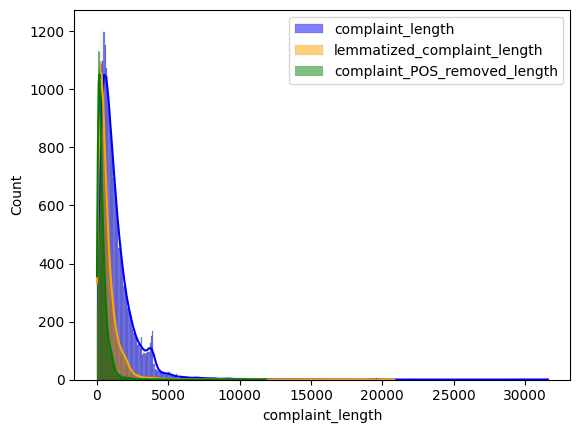

In [21]:
# Visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint'].str.len()
df_clean['lemmatized_complaint_length'] = df_clean['lemmatized_complaint'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()

sns.histplot(data=df_clean['complaint_length'], color='blue', alpha=0.5, kde=True, label='complaint_length')
sns.histplot(data=df_clean['lemmatized_complaint_length'], color='orange', alpha=0.5, kde=True, label='lemmatized_complaint_length')
sns.histplot(data=df_clean['complaint_POS_removed_length'], color='green', alpha=0.5, kde=True, label='complaint_POS_removed_length')
plt.legend()
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [22]:
import wordcloud
from wordcloud import WordCloud

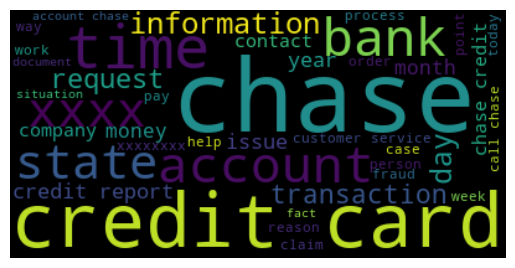

In [23]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud_text = " ".join(complaint for complaint in df_clean['complaint_POS_removed'])
wordcloud = WordCloud(max_words=40).generate(wordcloud_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,lemmatized_complaint_length,complaint_POS_removed_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...,486,289,148,morning help bank service write chase debt ver...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,355,205,112,card agent upgrade anniversary date change age...
10,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application submi...,chase card report application submit identity ...,224,132,101,chase card report application submit identity ...
11,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,1502,744,399,book offer ticket reward card information minu...
14,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,477,276,157,son deposit chase account fund bank account pa...
...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,679,364,264,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,2114,1148,694,credit card provider ask claim purchase protec...
78310,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer year trust mobile banking t...,2319,1341,694,xxxx risk consumer year trust mobile banking t...
78311,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ve chase credit card chase...,credit yrs credit card chase freedom problem t...,2171,984,487,credit yrs credit card chase freedom problem t...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [25]:
#WFunction to find n-gram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_grams(corpus, n=1, count=30):
    vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)
    vectorized = vec.transform(corpus)
    sum_words = vectorized.sum(axis=0)
    freq = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
    freq = sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:count]

In [28]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigram1 = get_top_n_grams(df_clean['Complaint_clean'], n=1, count=30)
for word, freq in unigram1:
    print(word, freq)

chase 51012
account 39594
credit 32933
card 29099
payment 20752
xxxx 20364
bank 15920
time 15532
charge 15039
day 12429
call 11691
money 11631
check 10927
loan 10062
report 10056
information 9301
letter 8892
fee 8671
state 8309
number 8293
month 8205
year 7985
customer 7901
pay 7860
dispute 7626
mortgage 7535
balance 7400
request 7350
transaction 7280
phone 7275


In [26]:
#Print the top 10 words in the unigram frequency
unigram = get_top_n_grams(df_clean['Complaint_clean'], n=1, count=10)
for word, freq in unigram:
    print(word, freq)

chase 51012
account 39594
credit 32933
card 29099
payment 20752
xxxx 20364
bank 15920
time 15532
charge 15039
day 12429


In [29]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram = get_top_n_grams(df_clean['Complaint_clean'], n=2, count=30)
for word, freq in bigram:
    print(word, freq)

credit card 12516
credit report 3822
chase credit 2969
customer service 2876
call chase 2647
account chase 2087
check account 2024
chase bank 1959
chase account 1938
debit card 1845
contact chase 1817
credit score 1664
bank account 1518
card account 1493
account account 1488
chase card 1435
card chase 1360
number xxxx 1250
interest rate 1242
phone number 1192
account credit 1132
money account 1123
business day 1102
chase customer 1099
credit account 1091
xxxx credit 1081
letter chase 1076
card company 1071
dispute charge 1020
account number 1019


In [30]:
#Print the top 10 words in the bigram frequency
bigram = get_top_n_grams(df_clean['Complaint_clean'], n=2, count=10)
for word, freq in bigram:
    print(word, freq)

credit card 12516
credit report 3822
chase credit 2969
customer service 2876
call chase 2647
account chase 2087
check account 2024
chase bank 1959
chase account 1938
debit card 1845


In [31]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigram = get_top_n_grams(df_clean['Complaint_clean'], n=3, count=30)
for word, freq in trigram:
    print(word, freq)

chase credit card 2134
credit card account 1028
credit card company 957
credit card chase 684
chase customer service 543
xxxx credit card 534
inquiry credit report 471
credit card credit 421
charge credit card 394
credit reporting agency 372
call customer service 334
card credit card 331
account credit card 324
credit report credit 308
credit card xxxx 292
credit card charge 291
credit card payment 282
customer service representative 275
chase auto finance 265
credit reporting act 255
chase card service 243
freedom credit card 227
bank credit card 227
account credit report 218
credit card service 217
account call chase 215
credit card balance 213
credit card statement 208
report credit report 198
victim identity theft 198


In [32]:
#Print the top 10 words in the trigram frequency
trigram = get_top_n_grams(df_clean['Complaint_clean'], n=3, count=10)
for word, freq in trigram:
    print(word, freq)

chase credit card 2134
credit card account 1028
credit card company 957
credit card chase 684
chase customer service 543
xxxx credit card 534
inquiry credit report 471
credit card credit 421
charge credit card 394
credit reporting agency 372


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [33]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [34]:
#All masked texts has been removed
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,lemmatized_complaint_length,complaint_POS_removed_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...,486,289,148,morning help bank service write chase debt ver...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,355,205,112,card agent upgrade anniversary date change age...
10,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application submi...,chase card report application submit identity ...,224,132,101,chase card report application submit identity ...
11,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,1502,744,399,book offer ticket reward card information minu...
14,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,477,276,157,son deposit chase account fund bank account pa...
...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,679,364,264,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,2114,1148,694,credit card provider ask claim purchase protec...
78310,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer year trust mobile banking t...,2319,1341,694,risk consumer year trust mobile banking tell ...
78311,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ve chase credit card chase...,credit yrs credit card chase freedom problem t...,2171,984,487,credit yrs credit card chase freedom problem t...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [35]:
#Code here to initialise the TfidfVectorizer 

tf_idf_vec = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [36]:
#WCode to create the Document Term Matrix by transforming the complaints column present in df_clean.
tf_idf = tf_idf_vec.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [37]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [38]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics)

In [39]:
nmf_model.fit(tf_idf)
len(tf_idf_vec.get_feature_names_out())

6356

In [40]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f"Top 15 words for TOPIC #{index}")
    print([tf_idf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n', "*"*50)

Top 15 words for TOPIC #0
['claim', 'customer', 'transaction', 'business', 'number', 'transfer', 'branch', 'day', 'fund', 'chase', 'deposit', 'bank', 'money', 'check', 'account']

 **************************************************
Top 15 words for TOPIC #1
['customer', 'reason', 'time', 'application', 'month', 'point', 'year', 'score', 'limit', 'purchase', 'account', 'balance', 'chase', 'credit', 'card']

 **************************************************
Top 15 words for TOPIC #2
['date', 'statement', 'property', 'balance', 'rate', 'year', 'home', 'pay', 'time', 'modification', 'month', 'chase', 'mortgage', 'loan', 'payment']

 **************************************************
Top 15 words for TOPIC #3
['letter', 'theft', 'score', 'dispute', 'remove', 'identity', 'file', 'account', 'reporting', 'debt', 'company', 'information', 'inquiry', 'credit', 'report']

 **************************************************
Top 15 words for TOPIC #4
['email', 'time', 'statement', 'overdraft', 's

In [41]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(tf_idf)


In [42]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1)

In [43]:
df_clean.head()

,complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,lemmatized_complaint_length,complaint_POS_removed_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...,486,289,148,morning help bank service write chase debt ver...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,355,205,112,card agent upgrade anniversary date change age...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application submi...,chase card report application submit identity ...,224,132,101,chase card report application submit identity ...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,1502,744,399,book offer ticket reward card information minu...,3
14,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,477,276,157,son deposit chase account fund bank account pa...,0


In [44]:
#Print the first 5 Complaint for each of the Topics
for i in range(5):
    print('\n', f"Complaints from Topic #{i}")
    temp = df_clean[df_clean['Topic']==i]
    for j in range(5):
        print(f"Complaint #{j+1}: ", temp.iloc[j]['complaint'])
    print('\n', "*"*50)


 Complaints from Topic #0
Complaint #1:  Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. 
In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. 
I have a right to know this information as a consumer. 

Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.
Complaint #2:  my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time  date happen XX/XX/2018 check number XXXX claim numb

In [45]:
df_clean.shape

(21072, 8)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [46]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0:"Bank Account services",
    1:"Credit card or prepaid card",
    2:"Others",
    3:"Theft/Dispute Reporting",
    4:"Mortgage/Loan",
}
#Replace Topics with Topic Names
df_clean['Topic_name'] = df_clean['Topic'].map(Topic_names)

In [47]:
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed,complaint_length,lemmatized_complaint_length,complaint_POS_removed_length,Complaint_clean,Topic,Topic_name
1,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help bank service write chase debt ver...,486,289,148,morning help bank service write chase debt ver...,0,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card tell agent upgrade anni...,card agent upgrade anniversary date change age...,355,205,112,card agent upgrade anniversary date change age...,1,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,chase card report fraudulent application submi...,chase card report application submit identity ...,224,132,101,chase card report application submit identity ...,3,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come offer apply tic...,book offer ticket reward card information minu...,1502,744,399,book offer ticket reward card information minu...,3,Theft/Dispute Reporting
14,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund cle...,son deposit chase account fund bank account pa...,477,276,157,son deposit chase account fund bank account pa...,0,Bank Account services
...,...,...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,679,364,264,chase card customer decade solicitation credit...,1,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,2114,1148,694,credit card provider ask claim purchase protec...,4,Mortgage/Loan
78310,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer year trust mobile banking t...,2319,1341,694,risk consumer year trust mobile banking tell ...,3,Theft/Dispute Reporting
78311,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ve chase credit card chase...,credit yrs credit card chase freedom problem t...,2171,984,487,credit yrs credit card chase freedom problem t...,2,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [48]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint','Topic']]

In [49]:
training_data

,complaint,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
10,Chase Card was reported on XX/XX/2019. However...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",3
14,my grand son give me check for {$1600.00} i de...,0
...,...,...
78303,After being a Chase Card customer for well ove...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",4
78310,I am not familiar with XXXX pay and did not un...,3
78311,I have had flawless credit for 30 yrs. I've ha...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [50]:

# Code to get the Vector count
vectorizor = CountVectorizer()
training_data_count = vectorizor.fit_transform(training_data['complaint'])

# Code to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
training_data_tf = tfidf_transformer.fit_transform(training_data_count)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [51]:
# importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [52]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(training_data_tf, training_data['Topic'], test_size=0.2, random_state=40)

In [57]:
# function to evaluate the model and display the results
def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    accuracy = round(accuracy_score(y_test,y_pred),2)
    precision = precision_score(y_test,y_pred,average='weighted').round(2)
    recall = recall_score(y_test,y_pred,average='weighted').round(2)
    f1score = f1_score(y_test,y_pred,average='weighted').round(2)
    roc_auc = roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr').round(2)
    eval_score = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1score,
        'ROC AUC Score': roc_auc
    }
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 Score: ', f1score)
    print('ROC AUC Score: ', roc_auc)
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    disp.plot()
    return eval_score

In [54]:
# function to grid search the best parameters for the model
def run_model(model,param_grid):
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid=param_grid,cv=cv,scoring='f1_weighted',verbose=10,n_jobs=-1)
    grid.fit(X_train,y_train)
    return grid.best_estimator_

In [55]:
# Dictionary to save scores of each model
final_model_scores = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'ROC AUC Score': []
    }

## 1. Logistic Regression

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Training results
Accuracy:  0.93
Precision:  0.93
Recall:  0.93
F1 Score:  0.93
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.93      0.95      0.94      4180
           1       0.93      0.94      0.93      3182
           2       0.95      0.96      0.95      4099
           3       0.93      0.89      0.91      1925
           4       0.93      0.91      0.92      3471

    accuracy                           0.93     16857
   macro avg       0.93      0.93      0.93     16857
weighted avg       0.93      0.93      0.93     16857

Test results
Accuracy:  0.92
Precision:  0.92
Recall:  0.92
F1 Score:  0.92
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.92      0.94      0.93      1040
           1       0.91      0.94      0.92       785
           2       0.93      0.96      

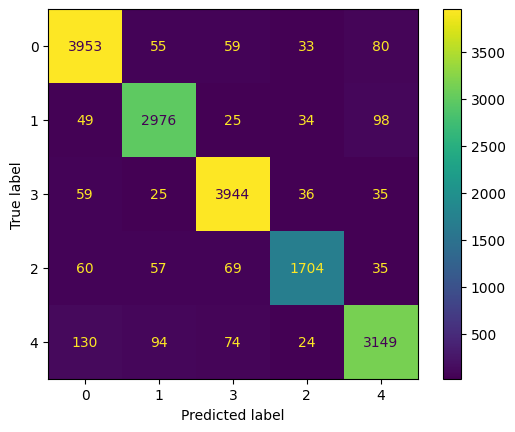

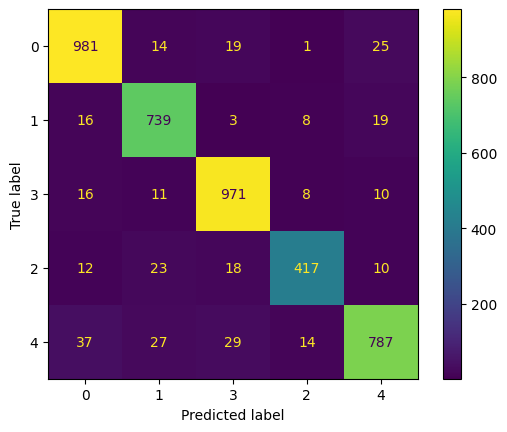

In [58]:
#running and evaluating the Logistic Regression model
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200, 300, 500],
}
lr_model=run_model(LogisticRegression(),params)
eval_model(y_train,lr_model.predict(X_train),lr_model.predict_proba(X_train),type='Training')
lr_model_scores = eval_model(y_test,lr_model.predict(X_test),lr_model.predict_proba(X_test),type='Test')

In [59]:

lr_model_scores['Model'] = 'Logistic Regression'
for key, val in lr_model_scores.items():
    final_model_scores[key].append(val)

## 2. Decision Tree





Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Training results
Accuracy:  0.87
Precision:  0.87
Recall:  0.87
F1 Score:  0.87
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.87      0.89      0.88      4180
           1       0.86      0.89      0.87      3182
           2       0.90      0.90      0.90      4099
           3       0.85      0.84      0.85      1925
           4       0.86      0.82      0.84      3471

    accuracy                           0.87     16857
   macro avg       0.87      0.87      0.87     16857
weighted avg       0.87      0.87      0.87     16857

Test results
Accuracy:  0.78
Precision:  0.78
Recall:  0.78
F1 Score:  0.78
ROC AUC Score:  0.92
Classification Report:                precision    recall  f1-score   support

           0       0.80      0.80      0.80      1040
           1       0.76      0.79      0.77       785
           2       0.82      0.84     

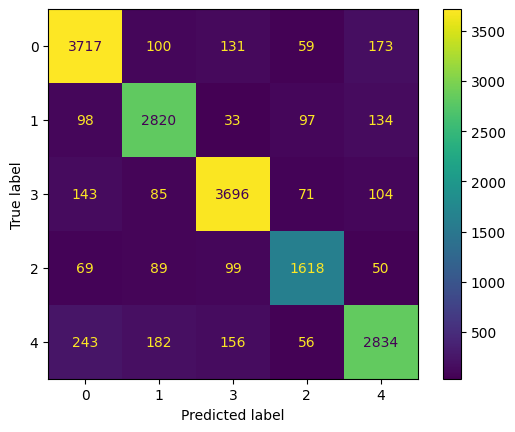

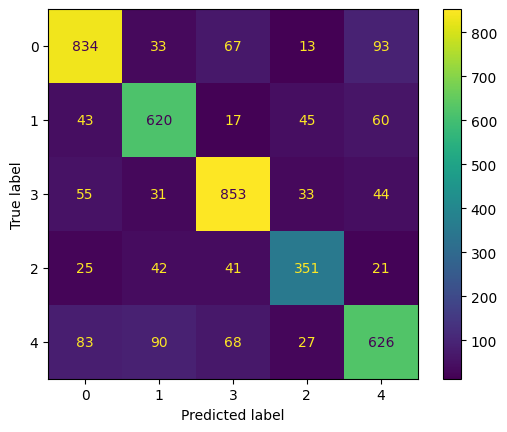

In [60]:
#running and evaluating the Decision Tree model
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 8, 10],
    'min_samples_split': [2, 4, 8, 10],
    'min_samples_leaf': [1, 2, 4, 8, 10],
}
dt_model=run_model(DecisionTreeClassifier(),params)
eval_model(y_train,dt_model.predict(X_train),dt_model.predict_proba(X_train),type='Training')
dt_model_scores = eval_model(y_test,dt_model.predict(X_test),dt_model.predict_proba(X_test),type='Test')

In [61]:
dt_model_scores['Model'] = "Decision Tree"
for key, val in dt_model_scores.items():
    final_model_scores[key].append(val)

## 3. Random Forest

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Training results
Accuracy:  0.99
Precision:  0.99
Recall:  0.99
F1 Score:  0.99
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       0.98      0.99      0.99      4180
           1       0.99      0.99      0.99      3182
           2       0.99      1.00      0.99      4099
           3       0.98      0.97      0.97      1925
           4       0.99      0.98      0.99      3471

    accuracy                           0.99     16857
   macro avg       0.99      0.98      0.99     16857
weighted avg       0.99      0.99      0.99     16857

Test results
Accuracy:  0.82
Precision:  0.82
Recall:  0.82
F1 Score:  0.82
ROC AUC Score:  0.97
Classification Report:                precision    recall  f1-score   support

           0       0.79      0.92      0.85      1040
           1       0.81      0.74      0.78       785
           2       0.84      0.92      

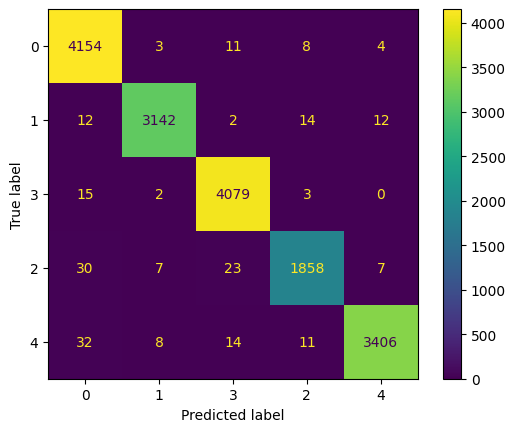

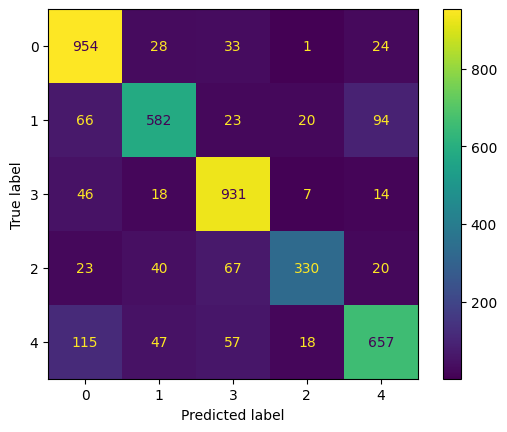

In [62]:
#running and evaluating the Random Forest model
params = {
    'n_estimators': [10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 8],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4, 8],
}
rf_model=run_model(RandomForestClassifier(),params)
eval_model(y_train,rf_model.predict(X_train),rf_model.predict_proba(X_train),type='Training')
rf_model_scores = eval_model(y_test,rf_model.predict(X_test),rf_model.predict_proba(X_test),type='Test')

In [63]:
rf_model_scores['Model'] = "Random Forest"
for key, val in rf_model_scores.items():
    final_model_scores[key].append(val)

## 4. Naive Bayes

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training results
Accuracy:  0.86
Precision:  0.86
Recall:  0.86
F1 Score:  0.85
ROC AUC Score:  0.98
Classification Report:                precision    recall  f1-score   support

           0       0.85      0.90      0.88      4180
           1       0.84      0.78      0.81      3182
           2       0.90      0.88      0.89      4099
           3       0.82      0.84      0.83      1925
           4       0.85      0.84      0.84      3471

    accuracy                           0.86     16857
   macro avg       0.85      0.85      0.85     16857
weighted avg       0.86      0.86      0.85     16857

Test results
Accuracy:  0.76
Precision:  0.76
Recall:  0.76
F1 Score:  0.76
ROC AUC Score:  0.94
Classification Report:                precision    recall  f1-score   support

           0       0.77      0.84      0.80      1040
           1       0.69      0.65      0.67       785
           2       0.83      0.81      0.

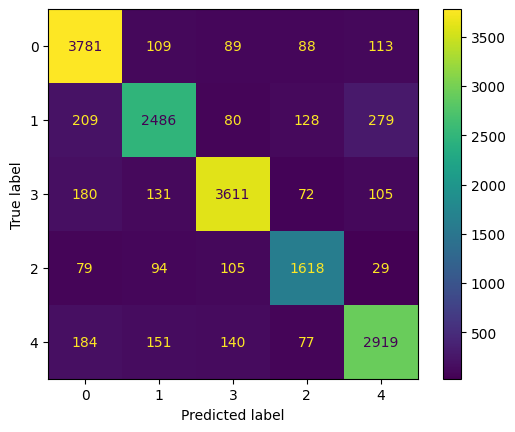

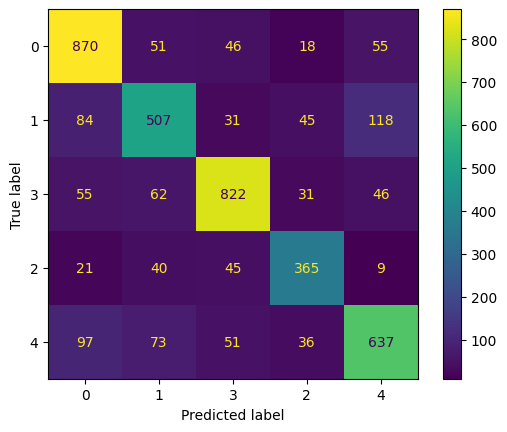

In [64]:
#running and evaluating the Gaussian Naive Bayes model
params = {
    'alpha': [0.1, 0.5, 1, 2, 5],
    'fit_prior': [True, False]
}
nb_model=run_model(MultinomialNB(),params)
eval_model(y_train,nb_model.predict(X_train),nb_model.predict_proba(X_train),type='Training')
nb_model_scores = eval_model(y_test,nb_model.predict(X_test),nb_model.predict_proba(X_test),type='Test')

In [65]:
nb_model_scores['Model'] = "Naive Bayes"
for key, val in nb_model_scores.items():
    final_model_scores[key].append(val)

In [66]:
final_model_scores_df = pd.DataFrame(final_model_scores)
final_model_scores_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,Logistic Regression,0.92,0.92,0.92,0.92,0.99
1,Decision Tree,0.78,0.78,0.78,0.78,0.92
2,Random Forest,0.82,0.82,0.82,0.82,0.97
3,Naive Bayes,0.76,0.76,0.76,0.76,0.94


##### Logistic Regression gives the best result among the 4 models tested

# Applying Logistic Regression model on Custom Complaints

In [67]:
# Creating dictionay of custom complaints
custom_text_dict = {
    'complaint': ["On XX/XX/XXXX, my credit card XXXX XXXX was charged twice for the same transaction at a restaurant. I contacted customer service, but they haven't resolved the issue yet.",
                "I applied for a prepaid card on XX/XX/XXXX, but it never arrived. When I try to check the status using my reference number, the website shows an error.",
                "I have been trying to close my savings account since XX/XX/XXXX, but every time I contact the bank, they tell me something different. It's frustrating!",
                "On XX/XX/XXXX, I was charged an overdraft fee on my checking account despite having sufficient funds at the time.",
                "Someone stole my card details XXXX XXXX and made fraudulent purchases on XX/XX/XXXX. I reported the issue, but it's taking too long to resolve.",
                "I raised a dispute for an unauthorized transaction on XX/XX/XXXX for my credit card (ending in XXXX), but I haven't received any updates for over a month.",
                "I applied for a home loan on XX/XX/XXXX, and it was approved, but there's been no communication on the disbursement process.",
                "My mortgage interest rate increased unexpectedly on XX/XX/XXXX, and now I can't afford my monthly payments.",
                "The bank's mobile app crashes every time I try to log in. I've contacted support since XX/XX/XXXX, but the problem persists.",
                "I visited a branch on XX/XX/XXXX to get help with my account, but the staff were rude and unhelpful."],
    'Actual_topic': [1,1,0,0,3,3,4,4,2,2],
    'Actual_topic_name': ["Credit card or prepaid card", "Credit card or prepaid card", "Bank Account services", "Bank Account services", "Theft/Dispute Reporting", "Theft/Dispute Reporting", "Mortgages/Loans", "Mortgages/Loans", "Others", "Others"]
}
custom_text_df = pd.DataFrame(custom_text_dict)
custom_text_df

,complaint,Actual_topic,Actual_topic_name
0,"On XX/XX/XXXX, my credit card XXXX XXXX was ch...",1,Credit card or prepaid card
1,"I applied for a prepaid card on XX/XX/XXXX, bu...",1,Credit card or prepaid card
2,I have been trying to close my savings account...,0,Bank Account services
3,"On XX/XX/XXXX, I was charged an overdraft fee ...",0,Bank Account services
4,Someone stole my card details XXXX XXXX and ma...,3,Theft/Dispute Reporting
5,I raised a dispute for an unauthorized transac...,3,Theft/Dispute Reporting
6,"I applied for a home loan on XX/XX/XXXX, and i...",4,Mortgages/Loans
7,My mortgage interest rate increased unexpected...,4,Mortgages/Loans
8,The bank's mobile app crashes every time I try...,2,Others
9,I visited a branch on XX/XX/XXXX to get help w...,2,Others


In [68]:
Topic_names = {
        0:"Bank Account services",
        1:"Credit card or prepaid card",
        2:"Others",
        3:"Theft/Dispute Reporting",
        4:"Mortgage/Loan",
    }

In [69]:
# Cleaning the complaints
custom_text_df['complaint_clean'] = custom_text_df['complaint'].apply(clean_text)
custom_text_df['complaint_lemmatized'] = custom_text_df['complaint_clean'].apply(lemmatize_text)
custom_text_df['complaint_pos_removed'] = custom_text_df['complaint_lemmatized'].apply(pos_tag)
custom_text_df['Complaint_final'] = custom_text_df['complaint_pos_removed'].str.replace('xxxx','')
custom_text_df['Complaint_final'] = custom_text_df['complaint_pos_removed'].str.replace('xxxxxxxx','')
    
custom_text_df

,complaint,Actual_topic,Actual_topic_name,complaint_clean,complaint_lemmatized,complaint_pos_removed,Complaint_final
0,"On XX/XX/XXXX, my credit card XXXX XXXX was ch...",1,Credit card or prepaid card,on xxxxxxxx my credit card xxxx xxxx was charg...,xxxxxxxx credit card xxxx xxxx charge twice tr...,xxxxxxxx credit card transaction restaurant co...,credit card transaction restaurant contact cu...
1,"I applied for a prepaid card on XX/XX/XXXX, bu...",1,Credit card or prepaid card,i applied for a prepaid card on xxxxxxxx but i...,apply prepaid card xxxxxxxx arrive try check s...,card status reference number website error,card status reference number website error
2,I have been trying to close my savings account...,0,Bank Account services,i have been trying to close my savings account...,try close saving account xxxxxxxx time contact...,saving account time bank frustrating,saving account time bank frustrating
3,"On XX/XX/XXXX, I was charged an overdraft fee ...",0,Bank Account services,on xxxxxxxx i was charged an overdraft fee on ...,xxxxxxxx charge overdraft fee checking account...,xxxxxxxx overdraft fee checking account fund time,overdraft fee checking account fund time
4,Someone stole my card details XXXX XXXX and ma...,3,Theft/Dispute Reporting,someone stole my card details xxxx xxxx and ma...,steal card detail xxxx xxxx fraudulent purchas...,card detail purchase xxxxxxxx report issue res...,card detail purchase report issue resolve
5,I raised a dispute for an unauthorized transac...,3,Theft/Dispute Reporting,i raised a dispute for an unauthorized transac...,raise dispute unauthorized transaction xxxxxxx...,dispute transaction xxxxxxxx credit card updat...,dispute transaction credit card update month
6,"I applied for a home loan on XX/XX/XXXX, and i...",4,Mortgages/Loans,i applied for a home loan on xxxxxxxx and it w...,apply home loan xxxxxxxx approve s communicati...,home loan xxxxxxxx communication disbursement ...,home loan communication disbursement process
7,My mortgage interest rate increased unexpected...,4,Mortgages/Loans,my mortgage interest rate increased unexpected...,mortgage interest rate increase unexpectedly x...,mortgage interest rate increase xxxxxxxx payment,mortgage interest rate increase payment
8,The bank's mobile app crashes every time I try...,2,Others,the banks mobile app crashes every time i try ...,bank mobile app crash time try log ve contact ...,crash time log contact support xxxxxxxx,crash time log contact support
9,I visited a branch on XX/XX/XXXX to get help w...,2,Others,i visited a branch on xxxxxxxx to get help wit...,visit branch xxxxxxxx help account staff rude ...,branch xxxxxxxx account staff rude unhelpful,branch account staff rude unhelpful


In [70]:
# Function to predict complaint Topic
def predict_complaint(text):
    custom_text_count = vectorizor.transform(text)
    custom_text_tf = tfidf_transformer.transform(custom_text_count)
    predicted = lr_model.predict(custom_text_tf)
    return Topic_names[predicted[0]]

In [71]:
custom_text_df['Predicted_topic_name'] = custom_text_df['Complaint_final'].apply(lambda x: predict_complaint([x]))
custom_text_df[['complaint','Actual_topic','Actual_topic_name','Predicted_topic_name']]

,complaint,Actual_topic,Actual_topic_name,Predicted_topic_name
0,"On XX/XX/XXXX, my credit card XXXX XXXX was ch...",1,Credit card or prepaid card,Credit card or prepaid card
1,"I applied for a prepaid card on XX/XX/XXXX, bu...",1,Credit card or prepaid card,Credit card or prepaid card
2,I have been trying to close my savings account...,0,Bank Account services,Bank Account services
3,"On XX/XX/XXXX, I was charged an overdraft fee ...",0,Bank Account services,Bank Account services
4,Someone stole my card details XXXX XXXX and ma...,3,Theft/Dispute Reporting,Theft/Dispute Reporting
5,I raised a dispute for an unauthorized transac...,3,Theft/Dispute Reporting,Credit card or prepaid card
6,"I applied for a home loan on XX/XX/XXXX, and i...",4,Mortgages/Loans,Others
7,My mortgage interest rate increased unexpected...,4,Mortgages/Loans,Others
8,The bank's mobile app crashes every time I try...,2,Others,Mortgage/Loan
9,I visited a branch on XX/XX/XXXX to get help w...,2,Others,Bank Account services
